# SUPERPOSED EPOCH ANALYSIS FOR THE ASY-H STORMS OF EACH INTENSITY CLASS

In [1]:
import pandas as pd
import utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

# Set seaborn styles for the plots
sns.set_style('whitegrid')
sns.set_context("paper")

In [2]:
print('Selecting storms based on the findings of the distribution of the maximum (minimum) of the ASY-H (SYM-H) index when grouping in 27 days to avoid persistence')
print('The found storms will be used to perform the superposed epoch analysis')

# Print threshold information for classification
print(f'Times when the ASY-H is below {utils.ASY_H_THRESHOLD_LOW} (percentile 60) will be ignored')
print(f'Times when the ASY-H is between {utils.ASY_H_THRESHOLD_LOW} and {utils.ASY_H_THRESHOLD_MODERATE} (percentile 80) will be classified as "LOW"')
print(f'Times when the ASY-H is between {utils.ASY_H_THRESHOLD_MODERATE} and {utils.ASY_H_THRESHOLD_INTENSE} (percentile 95) will be classified as "MODERATE"')
print(f'Times when the ASY-H is between {utils.ASY_H_THRESHOLD_INTENSE} and {utils.ASY_H_THRESHOLD_SUPERINTENSE} (percentile 99) will be classified as "INTENSE"')
print(f'Times when the ASY-H is above {utils.ASY_H_THRESHOLD_SUPERINTENSE} will be classified as "SUPERINTENSE"')

Selecting storms based on the findings of the distribution of the maximum (minimum) of the ASY-H (SYM-H) index when grouping in 27 days to avoid persistence
The found storms will be used to perform the superposed epoch analysis
Times when the ASY-H is below 130 (percentile 60) will be ignored
Times when the ASY-H is between 130 and 170 (percentile 80) will be classified as "LOW"
Times when the ASY-H is between 170 and 290 (percentile 95) will be classified as "MODERATE"
Times when the ASY-H is between 290 and 540 (percentile 99) will be classified as "INTENSE"
Times when the ASY-H is above 540 will be classified as "SUPERINTENSE"


In [3]:
# Read data from pickle file
dfx = pd.read_pickle('./sym_asy_indices.pkl', compression = 'gzip')

## ASY-H STORMS

In [4]:
# Extract dates with ASY-H index values above or equal to the low threshold
dates_asy = dfx['ASY_H'].reset_index().copy()
dates_asy = dates_asy.loc[dates_asy['ASY_H'] >= utils.ASY_H_THRESHOLD_LOW]

# Set the last valid year for storm classification
last_valid_year = 2022

# Initialize empty list to store storm data
storms_asy = []

Iterate over the dates with ASY-H values above the low intensity threhold.

* Calculate the start and end dates for the storm period based on the current date using one day as the offset.
* Find the maximum ASY-H value within the storm period.
* Find the index of the storm center (first occurrence of the maximum ASY-H value).
* Calculates the extended start and end dates for the storm period, considering 5 additional days before and after for the superposed epoch analysis.
* Checks if the end date exceeds the last valid year for classification and skips the current date if it does.
* Extracts the storm data within the extended period.
* Checks if there are more storms within the extended period with higher ASY-H values and updates the storm data accordingly.
* Checks if the new storm period overlaps with the previous storm and merges them if it does.
* Adds the new storm data to the list.

In [5]:
for i in tqdm(range(len(dates_asy))):
    st = dates_asy.iloc[i]['datetime'] - utils.MINIMUM_DAYS_BEFORE
    nd = dates_asy.iloc[i]['datetime'] + utils.MINIMUM_DAYS_AFTER
    storm_max = dfx[st:nd]['ASY_H'].max()      
    storm_center = dfx[st:nd].loc[dfx[st:nd]['ASY_H'] == storm_max].last_valid_index()    
    
    newst = storm_center - utils.SUPERPOSED_OFFSET_DAYS_BEFORE
    newst = newst.floor('D')
    newnd = storm_center + utils.SUPERPOSED_OFFSET_DAYS_AFTER
    newnd = newnd.ceil('D')
    
    if (newnd.year > last_valid_year):
        continue
    
    new_df = dfx[newst:newnd].copy()
    
    while new_df['ASY_H'].max() > storm_max:
        storm_center = dfx[newst:newnd].loc[dfx[newst:newnd]['ASY_H'] == storm_max].last_valid_index()
        newnd = storm_center + utils.SUPERPOSED_OFFSET_DAYS_AFTER
        newnd = newnd.ceil('D')
        new_df = dfx[newst : newnd].copy()
        storm_max = new_df[newst:newnd]['ASY_H'].max()        
    
    if (len(storms_asy) >= 1):
        if storms_asy[-1].index[-1] >= newst:
            new_df = pd.concat([storms_asy[-1], new_df])            
            new_df = new_df[~new_df.index.duplicated(keep='first')]
            storms_asy[-1] = new_df
            continue
    
    storms_asy.append(new_df)

  0%|          | 0/7782 [00:00<?, ?it/s]

In [6]:
print(f"Total storms: {len(storms_asy)}")    

Total storms: 257


In [7]:
# Create a summary dataframe with the start and end dates, the duration, the maximum ASY-H value 
# of the storm and the corresponding class of the storm
summary_df_asy = utils.get_summary_df_asy(storms_asy)
summary_df_asy['classification'] = 'LOW'
summary_df_asy.loc[(summary_df_asy['Max ASY-H'] >= utils.ASY_H_THRESHOLD_MODERATE) & (summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_INTENSE), 'classification'] = 'MODERATE'
summary_df_asy.loc[(summary_df_asy['Max ASY-H'] >= utils.ASY_H_THRESHOLD_INTENSE) & (summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_SUPERINTENSE), 'classification'] = 'INTENSE'
summary_df_asy.loc[summary_df_asy['Max ASY-H'] >= utils.ASY_H_THRESHOLD_SUPERINTENSE, 'classification'] = 'SUPERINTENSE'

In [8]:
# Display all the identified storms
with pd.option_context('display.max_rows', 400, 'display.max_columns', 20):
    display(summary_df_asy) 
print(f'Total storms shown: {len(summary_df_asy)}')

,Start date,End date,TD,Max ASY-H,classification
0,1981-02-28,1981-03-11,11 days,132,LOW
1,1981-04-08,1981-04-19,11 days,267,MODERATE
2,1981-05-05,1981-05-24,19 days,173,MODERATE
3,1981-07-20,1981-07-31,11 days,287,MODERATE
4,1981-10-09,1981-10-20,11 days,245,MODERATE
5,1982-01-28,1982-02-08,11 days,142,LOW
6,1982-02-25,1982-03-08,11 days,193,MODERATE
7,1982-07-09,1982-07-19,10 days,604,SUPERINTENSE
8,1982-08-02,1982-08-13,11 days,147,LOW
9,1982-09-01,1982-09-12,11 days,376,INTENSE


Total storms shown: 257


LOW             149
MODERATE         81
INTENSE          21
SUPERINTENSE      6
Name: classification, dtype: int64
Total number of storms: 257


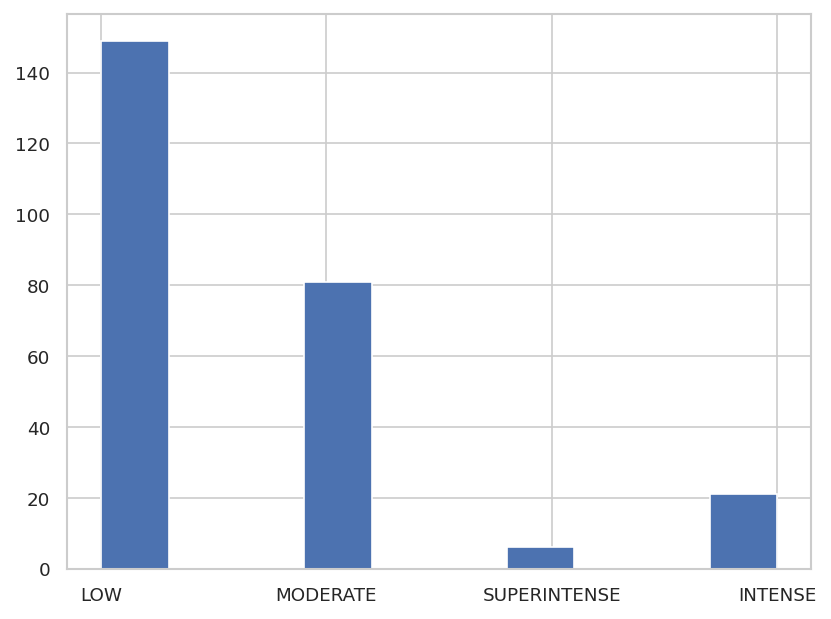

In [9]:
# Plot a histogram of the storm classifications
plt.hist(summary_df_asy['classification'], align='mid')
# Print the count of each storm classification
print(summary_df_asy['classification'].value_counts())
# Print the total number of storms
print('Total number of storms:', len(summary_df_asy))

In [10]:
# Get the indices of storms classified as 'LOW'
low_indices = summary_df_asy.loc[(summary_df_asy['Max ASY-H'] > utils.ASY_H_THRESHOLD_LOW ) & 
                                ((summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_MODERATE ))].index

# Get the indices of storms classified as 'MODERATE'
moderate_indices = summary_df_asy.loc[(summary_df_asy['Max ASY-H'] > utils.ASY_H_THRESHOLD_MODERATE ) & 
                                ((summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_INTENSE ))].index

# Get the indices of storms classified as 'INTENSE'
intense_indices  = summary_df_asy.loc[(summary_df_asy['Max ASY-H'] > utils.ASY_H_THRESHOLD_INTENSE ) & 
                                ((summary_df_asy['Max ASY-H'] < utils.ASY_H_THRESHOLD_SUPERINTENSE ))].index

# Get the indices of storms classified as 'SUPERINTENSE'
superintense_indices  = summary_df_asy.loc[summary_df_asy['Max ASY-H'] > utils.ASY_H_THRESHOLD_SUPERINTENSE].index

Evaluating for indices L_
Storm 0 1981-03-05 11:50:00 1981-03-10 11:50:00
Storm 5 1982-02-02 11:30:00 1982-02-07 11:30:00
Storm 8 1982-08-07 06:00:00 1982-08-12 06:00:00
Storm 11 1982-10-31 19:00:00 1982-11-05 19:00:00
Storm 13 1982-12-22 03:10:00 1982-12-27 03:10:00
Storm 16 1983-05-11 17:55:00 1983-05-16 17:55:00
Storm 18 1983-06-13 04:20:00 1983-06-18 04:20:00
Storm 19 1983-08-08 04:20:00 1983-08-13 04:20:00
Storm 20 1983-10-04 15:00:00 1983-10-09 15:00:00
Storm 21 1983-11-11 20:30:00 1983-11-16 20:30:00
Storm 23 1984-04-26 15:35:00 1984-05-01 15:35:00
Storm 24 1984-07-13 07:00:00 1984-07-18 07:00:00
Storm 25 1984-09-04 15:30:00 1984-09-09 15:30:00
Storm 26 1984-09-19 12:30:00 1984-09-24 12:30:00
Storm 27 1984-11-16 03:10:00 1984-11-21 03:10:00
Storm 28 1985-02-28 03:00:00 1985-03-05 03:00:00
Storm 29 1985-04-09 14:15:00 1985-04-14 14:15:00
Storm 31 1985-06-09 22:20:00 1985-06-14 22:20:00
Storm 32 1985-09-19 10:15:00 1985-09-24 10:15:00
Storm 33 1985-10-05 20:10:00 1985-10-10 20:10:

Storm 136 1998-08-27 08:25:00 1998-09-01 08:25:00
Storm 140 1998-11-08 06:00:00 1998-11-13 06:00:00
Storm 142 1999-02-18 10:40:00 1999-02-23 10:40:00
Storm 147 1999-10-22 07:25:00 1999-10-27 07:25:00
Storm 149 2000-02-12 12:05:00 2000-02-17 12:05:00
Storm 151 2000-05-24 03:30:00 2000-05-29 03:30:00
Storm 154 2000-08-12 03:40:00 2000-08-17 03:40:00
Storm 155 2000-09-17 22:30:00 2000-09-22 22:30:00
Storm 156 2000-10-05 12:15:00 2000-10-10 12:15:00
Storm 163 2002-04-19 13:30:00 2002-04-24 13:30:00
Storm 165 2002-05-23 12:20:00 2002-05-28 12:20:00
Storm 167 2002-10-01 11:20:00 2002-10-06 11:20:00
Storm 173 2003-07-12 05:40:00 2003-07-17 05:40:00
Storm 176 2003-09-17 13:35:00 2003-09-22 13:35:00
Storm 187 2005-05-15 08:45:00 2005-05-20 08:45:00
Storm 188 2005-05-30 15:05:00 2005-06-04 15:05:00
Storm 190 2005-09-11 06:35:00 2005-09-16 06:35:00
Storm 196 2006-12-15 00:05:00 2006-12-20 00:05:00
Storm 203 2011-08-05 21:50:00 2011-08-10 21:50:00
Storm 207 2012-03-09 09:55:00 2012-03-14 09:55:00


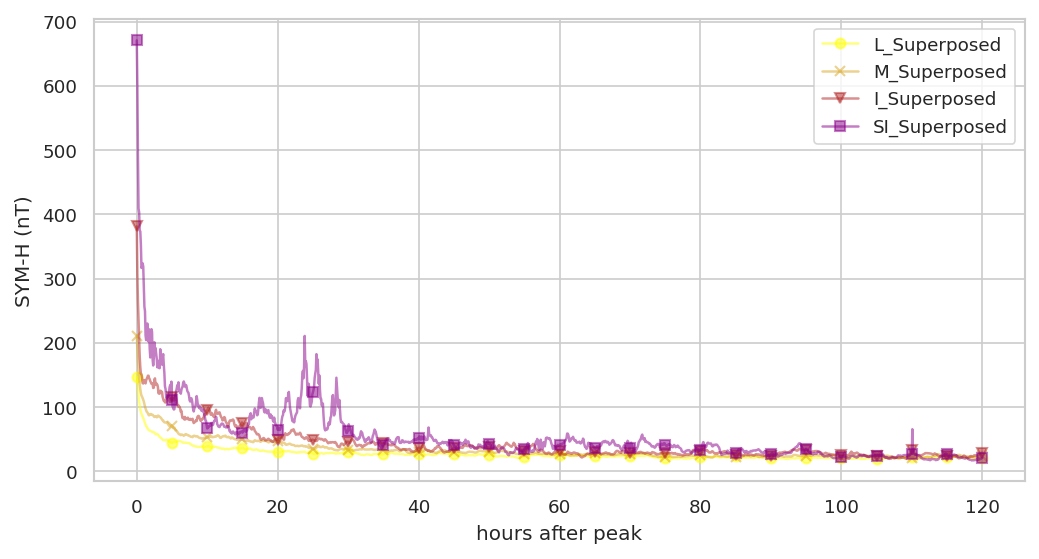

In [11]:
# Define names and indices for different storm classifications
names = ['L_', 'M_', 'I_', 'SI_']
names_long = ['Low_Storms', 'Moderate_Storms', 'Intense_Storms', 'SuperIntense_Storms']
classification = ['Low', 'Moderate', 'Intense', 'SuperIntense']
all_indices = [low_indices, moderate_indices, intense_indices, superintense_indices]

# Create a dataframe for the forward superposed epoch plot
superposed_forward = pd.DataFrame(index = pd.timedelta_range(start = '0 days', end = f'{utils.SUPERPOSED_DAYS_AFTER} days', freq = '5min'))
superposed_dfs_forward = []

# Define the time offset for the forward superposed epoch plot
delta_forward = pd.DateOffset(days = utils.SUPERPOSED_DAYS_AFTER)

for i in range(len(all_indices)):
    indices = all_indices[i]
    name = names[i]
    superposed_df = pd.DataFrame(index = pd.timedelta_range(start = '0 days', end = f'{utils.SUPERPOSED_DAYS_AFTER} days', freq = '5min'))
    
    print('Evaluating for indices',name)
    
    dfs_tmp = []
    
    for storm_index in indices:        
        strm = utils.get_storm(dfx, summary_df_asy, storm_index)
        strm = strm[['ASY_H']]        
        idxmax = strm['ASY_H'].idxmax()
        strm.columns = [[f'storm-{storm_index}']]
        strm = strm[idxmax : idxmax + delta_forward].copy()
        print('Storm', storm_index, strm.index[0], strm.index[-1])
        strm.index = pd.timedelta_range(start = '0 days', freq = '5min', periods = len(strm))        
        dfs_tmp.append(strm)   
        
    superposed_df = pd.concat(dfs_tmp, axis = 1)
    # Average the storms for the superposed epoch plot
    superposed_df[f'{name}Superposed'] = superposed_df.mean(axis = 1)
    superposed_dfs_forward.append(superposed_df.copy())
    
    superposed_forward[f'{name}Superposed'] = superposed_df[f'{name}Superposed']
    
        
superposed_forward['hours'] = superposed_forward.index / pd.Timedelta(hours = 1)

# Plot the superposed epoch storms for each class
fig, ax = plt.subplots(1, figsize = utils.global_figsize)
ax = superposed_forward.plot(x = 'hours', y ='L_Superposed', color = utils.COLOR_LOW, marker = 'o', ax = ax, markevery = 5 * 12, alpha = 0.5)
ax = superposed_forward.plot(x = 'hours', y ='M_Superposed', color = utils.COLOR_MODERATE, marker = 'x', ax = ax, markevery = 5 * 12, alpha = 0.5)
ax = superposed_forward.plot(x = 'hours', y ='I_Superposed', color = utils.COLOR_INTENSE, marker = "v", ax = ax, markevery = 5 * 12, alpha = 0.5)
ax = superposed_forward.plot(x = 'hours', y ='SI_Superposed', color = utils.COLOR_SUPERINTENSE, marker = "s", ax = ax, markevery = 5 * 12, alpha = 0.5, ylabel = 'SYM-H (nT)', xlabel = 'hours after peak')
plt.show();

Evaluating for indices L_
Storm 0 1981-02-28 11:50:00 1981-03-05 11:50:00
Storm 5 1982-01-28 11:30:00 1982-02-02 11:30:00
Storm 8 1982-08-02 06:00:00 1982-08-07 06:00:00
Storm 11 1982-10-26 19:00:00 1982-10-31 19:00:00
Storm 13 1982-12-17 03:10:00 1982-12-22 03:10:00
Storm 16 1983-05-06 17:55:00 1983-05-11 17:55:00
Storm 18 1983-06-08 04:20:00 1983-06-13 04:20:00
Storm 19 1983-08-03 04:20:00 1983-08-08 04:20:00
Storm 20 1983-09-29 15:00:00 1983-10-04 15:00:00
Storm 21 1983-11-06 20:30:00 1983-11-11 20:30:00
Storm 23 1984-04-21 15:35:00 1984-04-26 15:35:00
Storm 24 1984-07-08 07:00:00 1984-07-13 07:00:00
Storm 25 1984-08-30 15:30:00 1984-09-04 15:30:00
Storm 26 1984-09-14 12:30:00 1984-09-19 12:30:00
Storm 27 1984-11-11 03:10:00 1984-11-16 03:10:00
Storm 28 1985-02-23 03:00:00 1985-02-28 03:00:00
Storm 29 1985-04-04 14:15:00 1985-04-09 14:15:00
Storm 31 1985-06-04 22:20:00 1985-06-09 22:20:00
Storm 32 1985-09-14 10:15:00 1985-09-19 10:15:00
Storm 33 1985-09-30 20:10:00 1985-10-05 20:10:

Storm 105 1994-10-24 11:45:00 1994-10-29 11:45:00
Storm 106 1994-11-21 10:20:00 1994-11-26 10:20:00
Storm 110 1995-04-02 19:00:00 1995-04-07 19:00:00
Storm 117 1996-04-09 22:30:00 1996-04-14 22:30:00
Storm 119 1996-09-21 19:40:00 1996-09-26 19:40:00
Storm 131 1998-02-13 00:50:00 1998-02-18 00:50:00
Storm 132 1998-03-05 18:15:00 1998-03-10 18:15:00
Storm 136 1998-08-22 08:25:00 1998-08-27 08:25:00
Storm 140 1998-11-03 06:00:00 1998-11-08 06:00:00
Storm 142 1999-02-13 10:40:00 1999-02-18 10:40:00
Storm 147 1999-10-17 07:25:00 1999-10-22 07:25:00
Storm 149 2000-02-07 12:05:00 2000-02-12 12:05:00
Storm 151 2000-05-19 03:30:00 2000-05-24 03:30:00
Storm 154 2000-08-07 03:40:00 2000-08-12 03:40:00
Storm 155 2000-09-12 22:30:00 2000-09-17 22:30:00
Storm 156 2000-09-30 12:15:00 2000-10-05 12:15:00
Storm 163 2002-04-14 13:30:00 2002-04-19 13:30:00
Storm 165 2002-05-18 12:20:00 2002-05-23 12:20:00
Storm 167 2002-09-26 11:20:00 2002-10-01 11:20:00
Storm 173 2003-07-07 05:40:00 2003-07-12 05:40:00


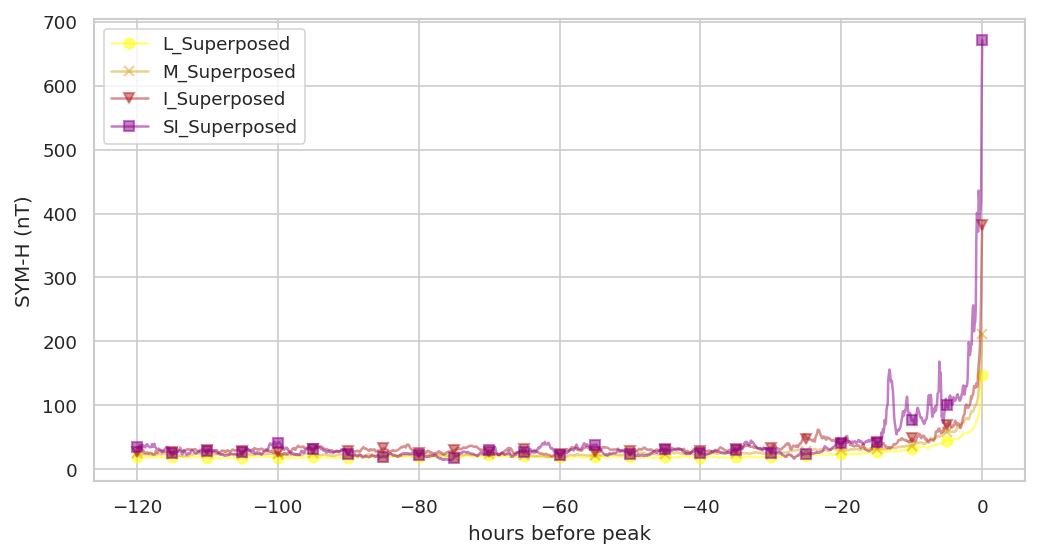

In [12]:
# Create a dataframe for the backward superposed epoch plot
superposed_backward = pd.DataFrame(index = pd.timedelta_range(start = f'-{utils.SUPERPOSED_DAYS_BEFORE} days', end = '0 days', freq = '5min'))
superposed_dfs_backward = []

# Define the time offset for the backward superposed epoch plot
delta_backward = pd.DateOffset(days = utils.SUPERPOSED_DAYS_BEFORE)

for i in range(len(all_indices)):
    indices = all_indices[i]
    name = names[i]
    superposed_df = pd.DataFrame(index = pd.timedelta_range(start = f'-{utils.SUPERPOSED_DAYS_BEFORE} days', end = '0 days', freq = '5min'))
    
    print('Evaluating for indices',name)
    
    dfs_tmp = []
    
    for storm_index in indices:        
        strm = utils.get_storm(dfx, summary_df_asy, storm_index)
        strm = strm[['ASY_H']]        
        idxmax = strm['ASY_H'].idxmax()
        strm.columns = [[f'storm-{storm_index}']]
        strm = strm[idxmax - delta_backward: idxmax].copy()
        print('Storm', storm_index, strm.index[0], strm.index[-1])
        strm.index = pd.timedelta_range(start = f'-{utils.SUPERPOSED_DAYS_AFTER} days', freq = '5min', periods = len(strm))        
        dfs_tmp.append(strm)        
    superposed_df = pd.concat(dfs_tmp, axis = 1)
    # Average the storms for the superposed epoch plot
    superposed_df[f'{name}Superposed'] = superposed_df.mean(axis = 1)
    superposed_dfs_backward.append(superposed_df.copy())
    
    superposed_backward[f'{name}Superposed'] = superposed_df[f'{name}Superposed']    
        
superposed_backward['hours'] = superposed_backward.index / pd.Timedelta(hours = 1)
fig, ax = plt.subplots(1, figsize = utils.global_figsize)
ax = superposed_backward.plot(x = 'hours', y ='L_Superposed', color = utils.COLOR_LOW, marker = 'o', ax = ax, markevery = 5 * 12, alpha = 0.5)
ax = superposed_backward.plot(x = 'hours', y ='M_Superposed', color = utils.COLOR_MODERATE, marker = 'x', ax = ax, markevery = 5 * 12, alpha = 0.5)
ax = superposed_backward.plot(x = 'hours', y ='I_Superposed', color = utils.COLOR_INTENSE, marker = "v", ax = ax, markevery = 5 * 12, alpha = 0.5)
ax = superposed_backward.plot(x = 'hours', y ='SI_Superposed', color = utils.COLOR_SUPERINTENSE, marker = "s", ax = ax, markevery = 5 * 12, alpha = 0.5, ylabel = 'SYM-H (nT)', xlabel = 'hours before peak')
plt.show();

In [13]:
# Create a dataframe for the superposed epoch plot in both directions
superposed_total = pd.DataFrame(index = pd.timedelta_range(start = f'-{utils.SUPERPOSED_DAYS_BEFORE} days', end = f'{utils.SUPERPOSED_DAYS_AFTER} days', freq = '5min'))
superposed_dfs_total = []
sum_cols = [ "Start date", "End date", "Max ASY-H", "Classification"]
# Columns for the output .csv with the dates used for the superposed epoch plot
dates_superposed = pd.DataFrame(columns = sum_cols)

for i in range(len(all_indices)):
    indices = all_indices[i]
    name = names[i]
    superposed_df = pd.DataFrame(index = pd.timedelta_range(start = f'-{utils.SUPERPOSED_DAYS_BEFORE} days', end = f'{utils.SUPERPOSED_DAYS_AFTER} days', freq = '5min'))
    
    print('Evaluating for indices',name)
    
    dfs_tmp = []
    
    for storm_index in indices:        
        strm = utils.get_storm(dfx, summary_df_asy, storm_index)
        strm = strm[['ASY_H']]        
        idxmax = strm['ASY_H'].idxmax()
        dates_superposed = pd.concat([dates_superposed, 
                                      pd.DataFrame(
                                          data = [[idxmax - delta_backward, 
                                                  idxmax + delta_forward,
                                                  strm['ASY_H'].max(),
                                                  classification[i]]],
                                          columns = sum_cols)], 
                                     ignore_index = True)
        strm.columns = [[f'storm-{storm_index}']]
        strm = strm[idxmax - delta_backward : idxmax + delta_forward].copy()
        print('Storm', storm_index, strm.index[0], strm.index[-1])
        strm.index = pd.timedelta_range(start = f'-{utils.SUPERPOSED_DAYS_BEFORE} days', freq = '5min', periods = len(strm))        
        dfs_tmp.append(strm)

    superposed_df = pd.concat(dfs_tmp, axis = 1)
    superposed_df[f'{name}Superposed'] = superposed_df.mean(axis = 1)
    superposed_dfs_total.append(superposed_df.copy())
    
    superposed_total[f'{name}Superposed'] = superposed_df[f'{name}Superposed']
    
        
superposed_total['hours'] = superposed_total.index / pd.Timedelta(hours = 1)

Evaluating for indices L_
Storm 0 1981-02-28 11:50:00 1981-03-10 11:50:00
Storm 5 1982-01-28 11:30:00 1982-02-07 11:30:00
Storm 8 1982-08-02 06:00:00 1982-08-12 06:00:00
Storm 11 1982-10-26 19:00:00 1982-11-05 19:00:00
Storm 13 1982-12-17 03:10:00 1982-12-27 03:10:00
Storm 16 1983-05-06 17:55:00 1983-05-16 17:55:00
Storm 18 1983-06-08 04:20:00 1983-06-18 04:20:00
Storm 19 1983-08-03 04:20:00 1983-08-13 04:20:00
Storm 20 1983-09-29 15:00:00 1983-10-09 15:00:00
Storm 21 1983-11-06 20:30:00 1983-11-16 20:30:00
Storm 23 1984-04-21 15:35:00 1984-05-01 15:35:00
Storm 24 1984-07-08 07:00:00 1984-07-18 07:00:00
Storm 25 1984-08-30 15:30:00 1984-09-09 15:30:00
Storm 26 1984-09-14 12:30:00 1984-09-24 12:30:00
Storm 27 1984-11-11 03:10:00 1984-11-21 03:10:00
Storm 28 1985-02-23 03:00:00 1985-03-05 03:00:00
Storm 29 1985-04-04 14:15:00 1985-04-14 14:15:00
Storm 31 1985-06-04 22:20:00 1985-06-14 22:20:00
Storm 32 1985-09-14 10:15:00 1985-09-24 10:15:00
Storm 33 1985-09-30 20:10:00 1985-10-10 20:10:

Storm 67 1990-04-05 14:00:00 1990-04-15 14:00:00
Storm 68 1990-05-21 22:05:00 1990-05-31 22:05:00
Storm 69 1990-06-07 21:35:00 1990-06-17 21:35:00
Storm 70 1990-07-23 23:10:00 1990-08-02 23:10:00
Storm 72 1990-10-05 09:40:00 1990-10-15 09:40:00
Storm 74 1990-11-22 17:10:00 1990-12-02 17:10:00
Storm 79 1991-08-25 13:05:00 1991-09-04 13:05:00
Storm 80 1991-09-26 21:45:00 1991-10-06 21:45:00
Storm 83 1992-02-03 15:00:00 1992-02-13 15:00:00
Storm 84 1992-02-21 17:30:00 1992-03-02 17:30:00
Storm 86 1992-06-07 13:45:00 1992-06-17 13:45:00
Storm 88 1992-09-04 12:40:00 1992-09-14 12:40:00
Storm 89 1992-09-24 09:30:00 1992-10-04 09:30:00
Storm 98 1993-12-03 01:05:00 1993-12-13 01:05:00
Storm 99 1994-02-17 00:55:00 1994-02-27 00:55:00
Storm 101 1994-04-12 08:40:00 1994-04-22 08:40:00
Storm 105 1994-10-24 11:45:00 1994-11-03 11:45:00
Storm 106 1994-11-21 10:20:00 1994-12-01 10:20:00
Storm 110 1995-04-02 19:00:00 1995-04-12 19:00:00
Storm 117 1996-04-09 22:30:00 1996-04-19 22:30:00
Storm 119 1996-

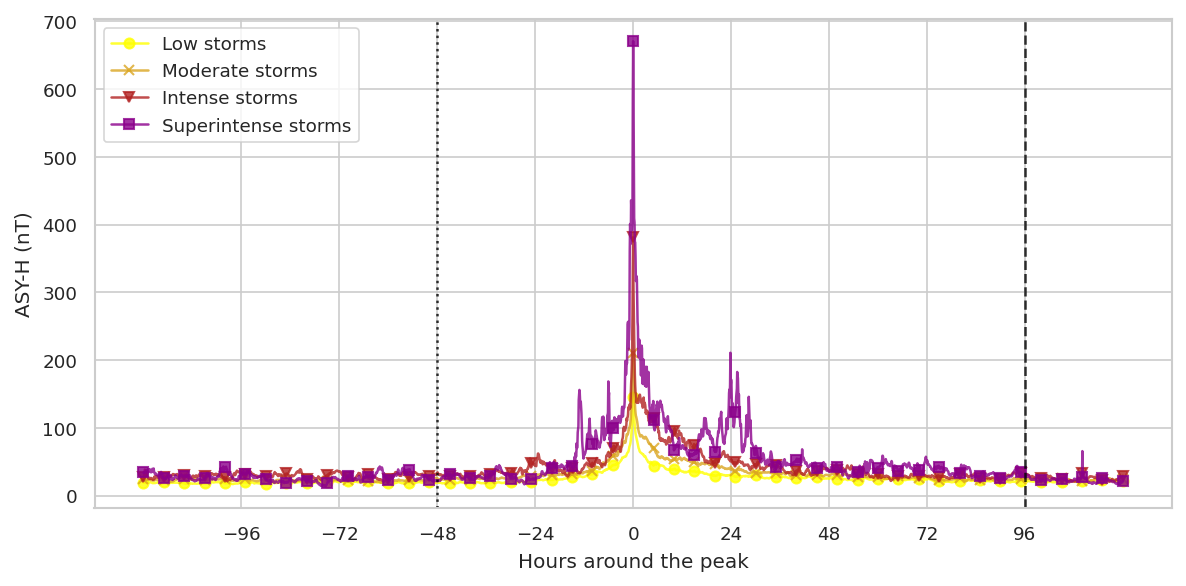

In [14]:
fig, ax = plt.subplots(1, figsize = utils.global_figsize)
ax = superposed_total.plot(x = 'hours', y ='L_Superposed', color = utils.COLOR_LOW, marker = 'o', ax = ax, markevery = 5 * 12, alpha = 0.8, label = 'Low storms')
ax = superposed_total.plot(x = 'hours', y ='M_Superposed', color = utils.COLOR_MODERATE, marker = 'x', ax = ax, markevery = 5 * 12, alpha = 0.8, label = 'Moderate storms')
ax = superposed_total.plot(x = 'hours', y ='I_Superposed', color = utils.COLOR_INTENSE, marker = "v", ax = ax, markevery = 5 * 12, alpha = 0.8, label = 'Intense storms')
ax = superposed_total.plot(x = 'hours', y ='SI_Superposed', color = utils.COLOR_SUPERINTENSE, marker = "s", ax = ax, markevery = 5 * 12, alpha = 0.8, ylabel = 'ASY-H (nT)', xlabel = 'Hours around the peak', label = 'Superintense storms')
ax.axvline(x = 24 * 4, linestyle = 'dashed', color = 'black', alpha = 0.8)
ax.axvline(x = -24 * 2, linestyle = 'dotted', color = 'black', alpha = 0.8)
ax.legend(['Low storms', 'Moderate storms', 'Intense storms', 'Superintense storms'])
plt.xticks([-96, -72, -48, -24, 0, 24, 48, 72, 96])
plt.tight_layout();
plt.savefig('figs/asy-superposed.png')
plt.show();

In [15]:
# Save the dates for the superposed epoch plot to a csv file in the format
# Start Date, End Date, Storm duration, Maximum ASY-H, Classification
dates_superposed.to_csv('dates_asy_superposed.csv', index = False)